<a href="https://colab.research.google.com/github/guilhermelaviola/LautaroInterGoalsAnalysis/blob/main/LautaroInterGoals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing all the necessary libraries:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
sns.set(style = 'darkgrid')
plt.style.use('seaborn-pastel')

<ipython-input-1-5ddc9a2f5ebc>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-pastel')


In [17]:
# Importing and displaying the dataset:
df = pd.read_excel('lautaro-goals.xlsx')
df.head()

,Competition,Round,Date,H/A,Against,Final score,Position,Minute,Which goal,How was it scored,Assist
0,Serie A TIM,7,2018-09-29,H,Cagliari,2-0,CF,12,1-0,Header,Dalbert
1,Serie A TIM,13,2018-11-24,H,Frosinone,3-0,CF,57,2-0,Header,Keita Baldé
2,Serie A TIM,18,2018-12-26,H,Napoli,1-0,CF,91,1-0,Left-footed shot,NaN
3,Coppa Italia,Round of 16,2019-01-13,H,Benevento,6-2,SS,48,4-0,Header,Ivan Perisic
4,Coppa Italia,Round of 16,2019-01-13,H,Benevento,6-2,SS,66,5-1,Right-footed shot,Ivan Perisic


I extracted this data from Transfermarkt.

In [19]:
# Displaying the number of rows and columns in the dataset:
df.shape

(119, 11)

The dataset has 118 rows at moment (12/09/2023). Each row represents a goal Lautaro scored for Inter. And there are 11 columns:
1. Competition
2. Round
3. Date
4. H/A - Home or Away
5. Against
6. Final Score
7. Position
8. Minute
9. Which goal
10. How was it scored
11. Assist



In [20]:
# Renaming the table columns:
df.columns = ['Competition', 'Round', 'Date',
              'Home or away', 'Against who',
              'Final score', 'Position',
              'Minute', 'Which goal',
              'How was it scored', 'Assist']

In [21]:
# Displaying the dataset after the columns were renamed:
df.head()

,Competition,Round,Date,Home or away,Against who,Final score,Position,Minute,Which goal,How was it scored,Assist
0,Serie A TIM,7,2018-09-29,H,Cagliari,2-0,CF,12,1-0,Header,Dalbert
1,Serie A TIM,13,2018-11-24,H,Frosinone,3-0,CF,57,2-0,Header,Keita Baldé
2,Serie A TIM,18,2018-12-26,H,Napoli,1-0,CF,91,1-0,Left-footed shot,NaN
3,Coppa Italia,Round of 16,2019-01-13,H,Benevento,6-2,SS,48,4-0,Header,Ivan Perisic
4,Coppa Italia,Round of 16,2019-01-13,H,Benevento,6-2,SS,66,5-1,Right-footed shot,Ivan Perisic


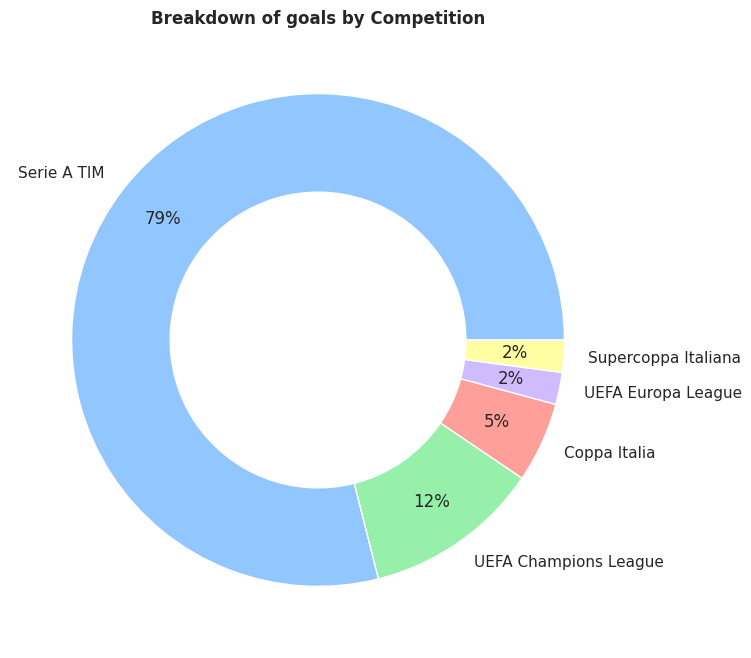

In [22]:
# Displaying goals scored by competition:
df.groupby('Date').first()['Competition'].value_counts().plot(kind = 'pie',
                                                              autopct = '%.0f%%',
                                                              figsize = (8, 8),
                                                              wedgeprops = dict(width = 0.4),
                                                              pctdistance = 0.8)
plt.ylabel(None)
plt.title('Breakdown of goals by Competition', fontweight = 'bold')
plt.show()

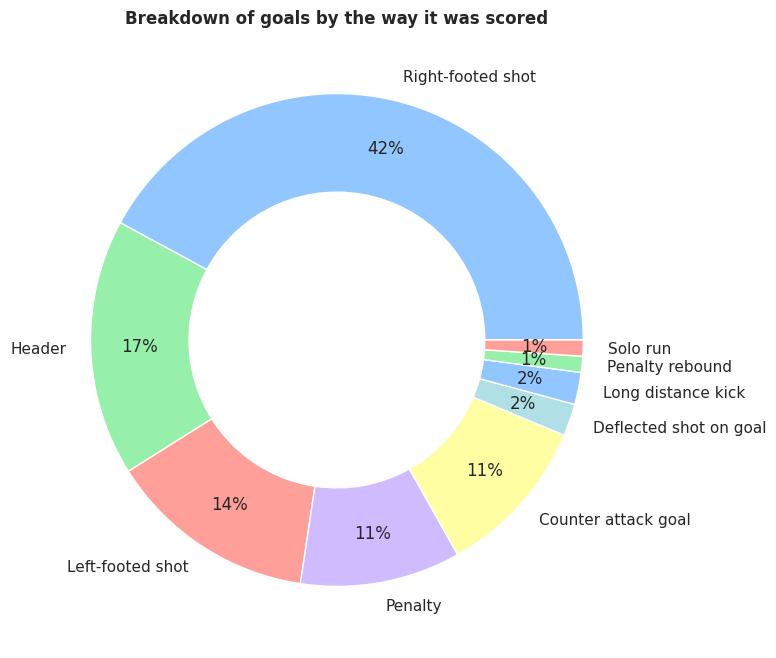

In [23]:
# Displaying goals scored by the way it was scored:
df.groupby('Date').first()['How was it scored'].value_counts().plot(kind = 'pie',
                                                              autopct = '%.0f%%',
                                                              figsize = (8, 8),
                                                              wedgeprops = dict(width = 0.4),
                                                              pctdistance = 0.8)
plt.ylabel(None)
plt.title('Breakdown of goals by the way it was scored', fontweight = 'bold')
plt.show()

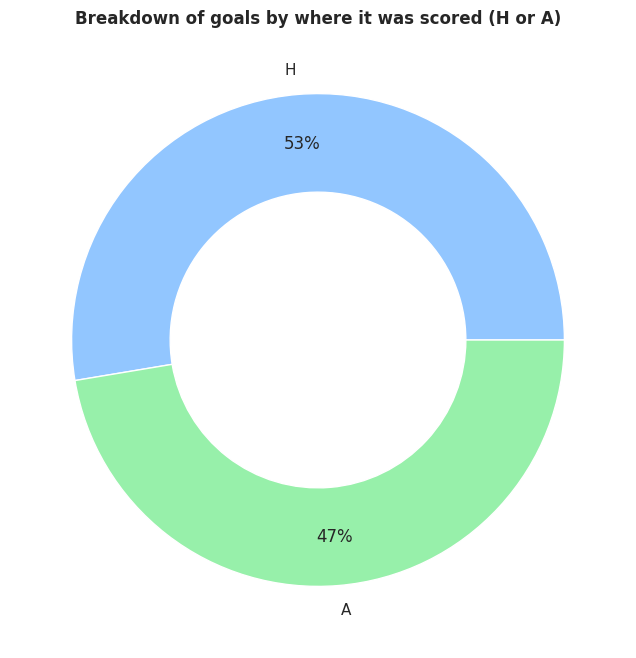

In [24]:
# Displaying goals scored by where it was scored (H or A):
df.groupby('Date').first()['Home or away'].value_counts().plot(kind = 'pie',
                                                              autopct = '%.0f%%',
                                                              figsize = (8, 8),
                                                              wedgeprops = dict(width = 0.4),
                                                              pctdistance = 0.8)
plt.ylabel(None)
plt.title('Breakdown of goals by where it was scored (H or A)', fontweight = 'bold')
plt.show()

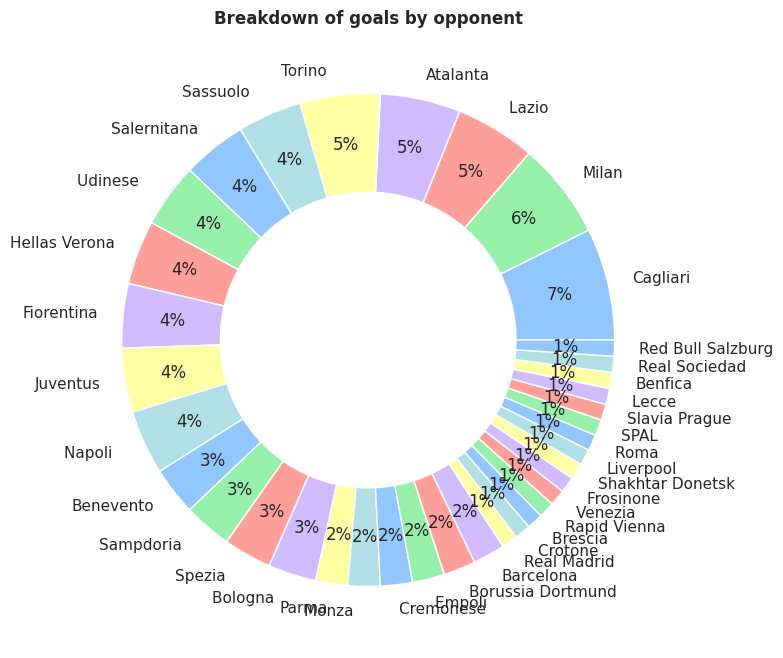

In [25]:
# Displaying goals scored by opponent:
df.groupby('Date').first()['Against who'].value_counts().plot(kind = 'pie',
                                                              autopct = '%.0f%%',
                                                              figsize = (8, 8),
                                                              wedgeprops = dict(width = 0.4),
                                                              pctdistance = 0.8)
plt.ylabel(None)
plt.title('Breakdown of goals by opponent', fontweight = 'bold')
plt.show()

In [26]:
df['Date'] = df['Date'].map(pd.to_datetime)
df['Day'] = df['Date'].apply(lambda x : x.day)
df['Month'] = df['Date'].apply(lambda x : x.month)
df['Year'] = df['Date'].apply(lambda x : x.year)

print(df.head())

    Competition        Round       Date Home or away  Against who Final score  \
0   Serie A TIM            7 2018-09-29            H     Cagliari         2-0   
1   Serie A TIM           13 2018-11-24            H  Frosinone           3-0   
2   Serie A TIM           18 2018-12-26            H     Napoli           1-0   
3  Coppa Italia  Round of 16 2019-01-13            H    Benevento         6-2   
4  Coppa Italia  Round of 16 2019-01-13            H    Benevento         6-2   

  Position  Minute Which goal  How was it scored        Assist  Day  Month  \
0       CF      12        1-0             Header       Dalbert   29      9   
1       CF      57        2-0             Header   Keita Baldé   24     11   
2       CF      91        1-0   Left-footed shot           NaN   26     12   
3       SS      48        4-0             Header  Ivan Perisic   13      1   
4       SS      66        5-1  Right-footed shot  Ivan Perisic   13      1   

   Year  
0  2018  
1  2018  
2  2018  
3  2

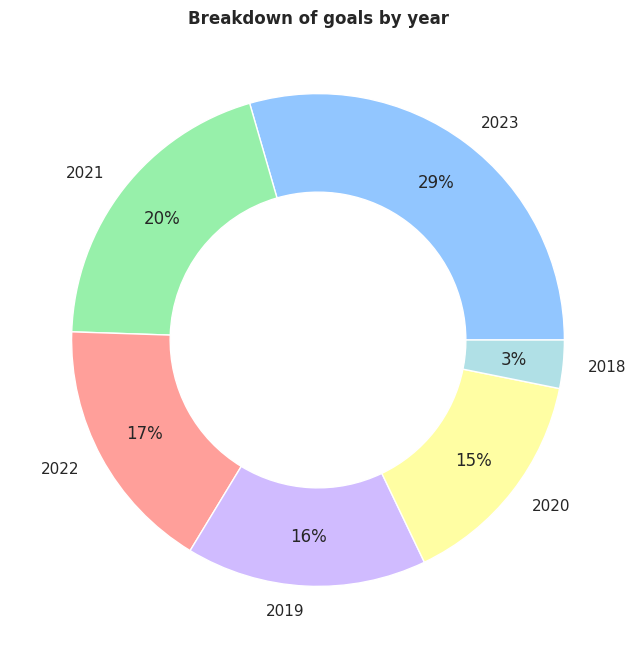

In [27]:
df.groupby('Date').first()['Year'].value_counts().plot(kind = 'pie',
                                                              autopct = '%.0f%%',
                                                              figsize = (8, 8),
                                                              wedgeprops = dict(width = 0.4),
                                                              pctdistance = 0.8)
plt.ylabel(None)
plt.title('Breakdown of goals by year', fontweight = 'bold')
plt.show()

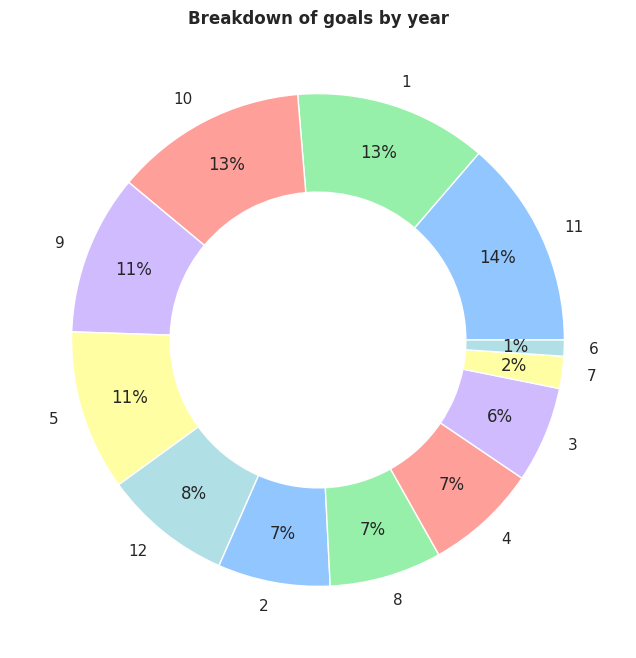

In [28]:
df.groupby('Date').first()['Month'].value_counts().plot(kind = 'pie',
                                                              autopct = '%.0f%%',
                                                              figsize = (8, 8),
                                                              wedgeprops = dict(width = 0.4),
                                                              pctdistance = 0.8)
plt.ylabel(None)
plt.title('Breakdown of goals by year', fontweight = 'bold')
plt.show()

<Axes: xlabel='Month', ylabel='Year'>

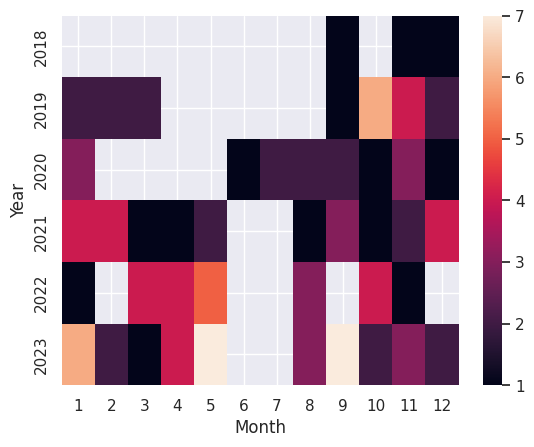

In [29]:
# Correlation of Year and Month with heatmap:
corr = df.groupby(['Year', 'Month']).apply(lambda x : len(x))
corr = corr.unstack()
sns.heatmap(corr, annot = False)

In [32]:
def scored_in_first_or_second_half(timing):
  if timing < 45:
    result = 'First half'
  else:
    result = 'Second half'
  return result

df['First or Second Half'] = df['Minute'].apply(scored_in_first_or_second_half)
df.head(10)

,Competition,Round,Date,Home or away,Against who,Final score,Position,Minute,Which goal,How was it scored,Assist,Day,Month,Year,First or Second Half
0,Serie A TIM,7,2018-09-29,H,Cagliari,2-0,CF,12,1-0,Header,Dalbert,29,9,2018,First half
1,Serie A TIM,13,2018-11-24,H,Frosinone,3-0,CF,57,2-0,Header,Keita Baldé,24,11,2018,Second half
2,Serie A TIM,18,2018-12-26,H,Napoli,1-0,CF,91,1-0,Left-footed shot,NaN,26,12,2018,Second half
3,Coppa Italia,Round of 16,2019-01-13,H,Benevento,6-2,SS,48,4-0,Header,Ivan Perisic,13,1,2019,Second half
4,Coppa Italia,Round of 16,2019-01-13,H,Benevento,6-2,SS,66,5-1,Right-footed shot,Ivan Perisic,13,1,2019,Second half
5,Serie A TIM,23,2019-02-09,A,Parma,0-1,CF,79,0-1,Right-footed shot,Radja Nainggolan,9,2,2019,Second half
6,UEFA Europa League,intermediate stage,2019-02-14,A,Rapid Vienna,0-1,CF,39,0-1,Penalty,NaN,14,2,2019,First half
7,Serie A TIM,26,2019-03-01,A,Cagliari,2-1,CF,38,1-1,Header,Radja Nainggolan,1,3,2019,First half
8,Serie A TIM,28,2019-03-17,A,Milan,2-3,CF,68,1-3,Penalty,NaN,17,3,2019,Second half
9,Serie A TIM,2,2019-09-01,A,Cagliari,1-2,SS,27,0-1,Header,Stefano Sensi,1,9,2019,First half


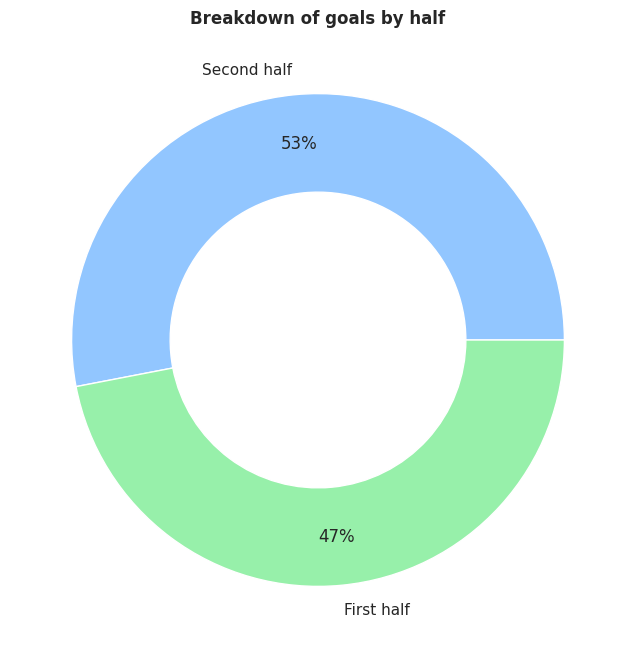

In [36]:
df.groupby('Minute').first()['First or Second Half'].value_counts().plot(kind = 'pie',
                                                              autopct = '%.0f%%',
                                                              figsize = (8, 8),
                                                              wedgeprops = dict(width = 0.4),
                                                              pctdistance = 0.8)
plt.ylabel(None)
plt.title('Breakdown of goals by half', fontweight = 'bold')
plt.show()

In [ ]:
# Adding Racing Bar animation for :
df.Date = pd.to_datetime(df.Date, format = '%Y')

In [ ]:
#Preparing a pivot table:
racing_bar_data = df.pivot_table(values = 'Against who', index = 'Date', columns = 'Competition')

<ipython-input-12-796136b4e6b4>:2: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  racing_bar_data = df.pivot_table(values = 'Against who', index = 'Date', columns = 'Competition')


In [ ]:
# Checking if there are any null value in the pivot table:
racing_bar_data.columns[racing_bar_data.isnull().sum() == 0]

Index([], dtype='object', name='Competition')

In [ ]:
# Converting the data into a cumulative sum over several years:
racing_bar_filled = racing_bar_data.interpolate(method = 'linear').fillna(method = 'bfill')
racing_bar_filled = racing_bar_filled.cumsum()

In [ ]:
# Oversampling the dataset with interpolation (linear) for a smooth transition in the frames of the snimation:
racing_bar_filled = racing_bar_filled.resample('1D').interpolate(method = 'linear')[::7]

ValueError: ignored

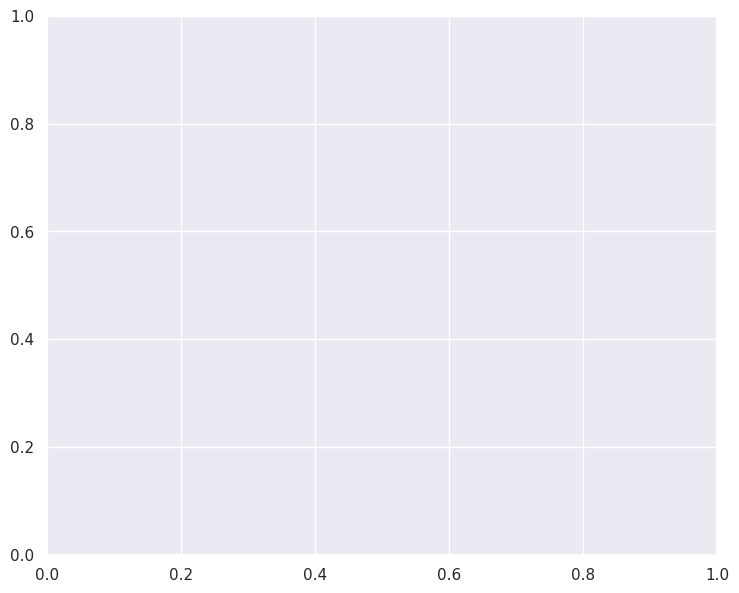

In [ ]:
# Creating and saving a Bar Chart Animation:
selected = racing_bar_filled.iloc[-1, :].sort_values(ascending = False)[:20].index
data = racing_bar_filled[selected].round()

fig, ax = plt.subplots(figsize = (9.3, 7))
fig.subplots_adjust(left = 0.18)

#Number of frames:
no_of_frames = data.shape[0]

# Initiating the barplot with the first rows of the dataframe:
bars = sns.barplot(y = data.columns, x = data.iloc[0, :], orient = 'h', ax = ax)
ax.set_xlim(0, 1500)
texts = [ax.text(0, i, 0, va = 'center') for i in range(data.shape[1])]
title_text = ax.text(650, -1, 'Date: ', fontsize = 12)
ax.set_xlabel(' ')
ax.set_ylabel(None)

def animate(i):
  y = data.iloc[i, :]

  # Updating the title of the barplot axis:
  title_text.set_text(f'Date: {str(data.index[i].date())}')

  # updating elements in both plots:
  for j, b, in enumerate(bars.patches):
    # updating each bar's height:
    b.set_width(y[j])

    # updating text for each bar (optional)
    texts[j].set_text(f'${y[j].astype(int)}M')
    texts[j].set_x(y[j])

animation = FuncAnimation(fig, animate, repeat = False,
                          frames = no_of_frames,
                          interval = 1, blit = False)
animation.save('goals.gif', writer = 'imagemagick', fps = 120)
plt.close(fig)